# Amazon Deep Racer - Reinforcement Learning

AWS DeepRacer is an AWS Machine Learning service for exploring reinforcement learning that is focused on autonomous racing. The AWS DeepRacer service supports the following features:



1.   Train a reinforcement learning model on the cloud.
2.   Evaluate a trained model in the AWS DeepRacer console.
3.   Submit a trained model to a virtual race and, if qualified, have its performance posted to the event's leaderboard.
4. Clone a trained model to continue training for improved performances.
5. Download the trained model artifacts for uploading to an AWS DeepRacer vehicle.
6. Place the vehicle on a physical track for autonomous driving and evaluate the model for real-world performances.

Reinforcement learning is a machine learning method that is focused on autonomous decision-making by an agent in order to achieve specified goals through interactions with an environment. In reinforcement learning, learning is achieved through trial and error and training does not require labeled input. Training relies on the reward hypothesis, which posits that all goals can be achieved by maximizing a future reward after action sequences. In reinforcement learning, designing the reward function is important. Better-crafted reward functions result in better decisions by the agent.












### Reinforcement learning reward function

In [ ]:
"""
Import required packages
"""
import math

"""
Constants
"""
MAX_REWARD = 1e2
MIN_REWARD = 1e-3
DIRECTION_THRESHOLD = 10.0
ABS_STEERING_THRESHOLD = 20

"""
Rewards function
"""
def reward_function(params):
    
    """
    Instantiate parameters
    """
    on_track = params['all_wheels_on_track']
    distance_from_center = params['distance_from_center']
    track_width = params['track_width']

    steering = abs(params['steering_angle']) # Only need the absolute steering angle for calculations
    
    speed = params['speed']
    waypoints = params['waypoints']
    closest_waypoints = params['closest_waypoints'] 
    heading = params['heading']
    
    # negative exponential penalty
    reward = math.exp(-6 * distance_from_center)
    
    """
    Define all reward functions
    """
    def on_track_reward(
        current_reward, 
        on_track
        ):
      
        # This reward serves as the primary reward - checking first and foremost if the vehicle is on the track
            
        if not on_track:
            current_reward = MIN_REWARD
        else:
            current_reward = MAX_REWARD
            
        return current_reward
        
    def distance_from_center_reward(
        current_reward, 
        track_width, 
        distance_from_center
        ):
            
        # Calculate 3 marks that are farther and father away from the center line
        marker_1 = 0.1 * track_width
        marker_2 = 0.25 * track_width
        marker_3 = 0.5 * track_width

        # Give higher reward if the car is closer to center line and penalize if further

        if distance_from_center <= marker_1:
            current_reward *= 1.4
        elif distance_from_center <= marker_2:
            current_reward *= 0.8
        elif distance_from_center <= marker_3:
            current_reward += 0.5
        else:
            current_reward = MIN_REWARD  # likely crashed/ close to off track

        return current_reward
        
    def straight_line_reward(
        current_reward, 
        steering, 
        speed
        ):
            
        # This is to optimize race speed, rewarding the car for going faster at smaller steering angles (straights)

        if abs(steering) < 0.1 and speed > 2:
            current_reward *= 1.5
            
        return current_reward
        
    def direction_reward(
        current_reward, 
        waypoints, 
        closest_waypoints, 
        heading
        ):

        next_point = waypoints[closest_waypoints[1]]
        prev_point = waypoints[closest_waypoints[0]]

        # Calculate the direction in radius, arctan2(dy, dx), the result is (-pi, pi) in radians
        direction = math.atan2(next_point[1] - prev_point[1], next_point[0] - prev_point[0]) 
        # Convert to degrees
        direction = math.degrees(direction)

        # Cacluate difference between track direction and car heading angle
        direction_diff = abs(direction - heading)

        # Penalize if car is heading away from track direction
        if direction_diff > DIRECTION_THRESHOLD:
            current_reward *= 0.3

        return current_reward
        
    def steering_reward(
        current_reward, 
        steering
        ):
            
        # Penalize reward if the car is steering too much
        if abs(steering) > ABS_STEERING_THRESHOLD:
            current_reward += 0.6
        return current_reward

    def throttle_reward(
        current_reward, 
        speed, 
        steering
        ):
            
        # Promotes safe corners, incentivising slowing down through corners
        if speed > 2 - (0.4 * abs(steering)):
            current_reward *= 0.8
        return current_reward
    
    """
    Execute all reward functions
    """
    
    primary_reward = on_track_reward(reward, on_track)

    reward = distance_from_center_reward(primary_reward, track_width, distance_from_center)
    reward = straight_line_reward(reward, steering, speed)
    reward = direction_reward(reward, waypoints, closest_waypoints, heading)
    reward = steering_reward(reward, steering)
    reward = throttle_reward(reward, speed, steering)

    final_reward = reward

    return float(final_reward)

Model Action Space:



The model action space is the set of possible outputs the model can take, relating to the real-world actions. The action space chosen for this project was a discrete action space, describing a set of steering angles and speed choices the model may take:

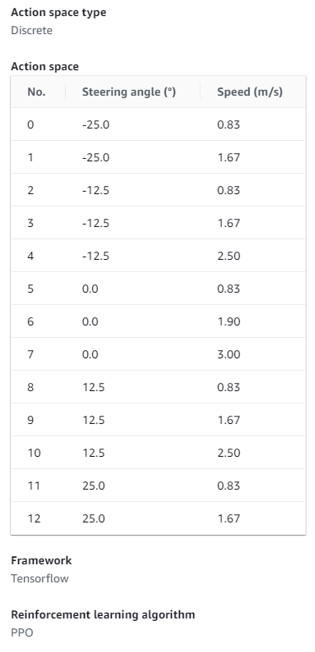

Model hyper parameters:

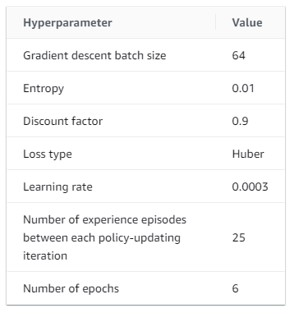